In [1]:
import sklearn

In [2]:
sklearn.__all__

['calibration',
 'cluster',
 'covariance',
 'cross_decomposition',
 'datasets',
 'decomposition',
 'dummy',
 'ensemble',
 'exceptions',
 'experimental',
 'externals',
 'feature_extraction',
 'feature_selection',
 'gaussian_process',
 'inspection',
 'isotonic',
 'kernel_approximation',
 'kernel_ridge',
 'linear_model',
 'manifold',
 'metrics',
 'mixture',
 'model_selection',
 'multiclass',
 'multioutput',
 'naive_bayes',
 'neighbors',
 'neural_network',
 'pipeline',
 'preprocessing',
 'random_projection',
 'semi_supervised',
 'svm',
 'tree',
 'discriminant_analysis',
 'impute',
 'compose',
 'clone',
 'get_config',
 'set_config',
 'config_context',
 'show_versions']

In [ ]:
import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm  

!apt-get update -qq
!apt-get install fonts-nanum* -qq

font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()
matplotlib.rcParams['axes.unicode_minus'] = False

!pip install catboost
!pip install pycaret
from tqdm.notebook import tqdm
from pycaret.regression import *
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ===DATA===

train = pd.read_csv('/content/drive/MyDrive/gh/kaggle/dacon/bicycle/dataset/train.csv')
test = pd.read_csv('/content/drive/MyDrive/gh/kaggle/dacon/bicycle/dataset/test.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/gh/kaggle/dacon/bicycle/dataset/sample_submission.csv')
# train.head(20)

In [ ]:
# ===UTILS===

# 1. seperate datetime
def seperate_datetime(dataframe):
    year = []
    month = []
    day = []

    for date in dataframe.date_time:
        year_point, month_point, day_point = date.split('-') # - 기준으로 string을 나누고 list로 만듦 ex) '2016-04-01' -> ['2016', '04', '01']
        year.append(int(year_point)-2017)
        month.append(int(month_point)-3)
        day.append(int(day_point))
    return year, month, day


# 2. weekday
def create_weekday(dataframe):
    week_day = pd.to_datetime(dataframe['date_time']).dt.day_name()
    le = LabelEncoder()
    le.fit(week_day)
    return le.transform(week_day)

# 3. weekend
def holiday_cat(week_day):
  if week_day in ['Sunday'] :
    return 1
  else :
    return 0


def create_weekend(dataframe):
    week_day = pd.to_datetime(dataframe['date_time']).dt.day_name()
    dataframe['week_day'] = week_day
    return dataframe.apply(lambda x : holiday_cat(x['week_day']), axis = 1)


# 4. Calculate humidex
def humidex(tmp, hum):
    result = 0.81*tmp + 0.01*hum * (0.99* tmp - 14.3) + 46.3
    return result


def calculate_discomfort_index(dataframe):
    return dataframe.apply(lambda x : humidex(x['high_temp'], x['humidity']), axis=1)
    

# 5. Calculate NMAE
def NMAE(true, pred):
    return -np.mean(np.abs(true-pred) / true)



In [ ]:
year, month, day = seperate_datetime(train)
week_day = create_weekday(train)
humidex_train = calculate_discomfort_index(train)
weekend_train = create_weekend(train)

train['year'] = year
train['month'] = month
train['day'] = day
train['week_day'] = week_day
train['humidex'] = humidex_train
train['weekend'] = weekend_train
train['ideal'] = train[['high_temp', 'wind_speed']].apply(lambda x: (0, 1)[x['high_temp'] > 24 and x['wind_speed'] < 30], axis = 1)


year, month, day = seperate_datetime(test) #날짜 숫자로 분리 후 
week_day = create_weekday(test)
humidex_test = calculate_discomfort_index(test)
weekend_test = create_weekend(test)

test['year'] = year 
test['month'] = month
test['day'] = day
test['week_day'] = week_day
test['humidex'] = humidex_test
test['weekend'] = weekend_test
test['ideal'] = test[['high_temp', 'wind_speed']].apply(lambda x: (0, 1)[x['high_temp'] > 27 and x['wind_speed'] < 30], axis = 1)


#
test_data = test.copy()
# test_data = test_data.drop(['wind_direction', 'Precipitation_Probability'], axis=1)
# train = train.drop(['wind_direction', 'Precipitation_Probability'], axis=1)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date_time                  273 non-null    object 
 1   wind_direction             273 non-null    float64
 2   sky_condition              273 non-null    float64
 3   precipitation_form         273 non-null    float64
 4   wind_speed                 273 non-null    float64
 5   humidity                   273 non-null    float64
 6   low_temp                   273 non-null    float64
 7   high_temp                  273 non-null    float64
 8   Precipitation_Probability  273 non-null    float64
 9   number_of_rentals          273 non-null    int64  
 10  week_day                   273 non-null    int64  
 11  year                       273 non-null    int64  
 12  month                      273 non-null    int64  
 13  day                        273 non-null    int64  

In [ ]:
train.head(50)

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals,week_day,year,month,day,humidex,weekend,ideal
0,2018-04-01,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994,3,1,1,1,68.177500,1,0
1,2018-04-02,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139,1,1,1,2,64.839468,0,0
2,2018-04-03,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817,5,1,1,3,59.352046,0,0
3,2018-04-04,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034,6,1,1,4,54.841094,0,0
4,2018-04-05,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833,4,1,1,5,51.802038,0,0
5,2018-04-06,256.412,3.466,0.358,3.734,68.885,2.500,9.895,40.068,13297,0,1,1,6,51.212404,0,0
6,2018-04-07,288.858,1.912,0.000,4.824,45.541,1.938,10.947,9.122,13088,2,1,1,7,53.590227,0,0
7,2018-04-08,200.939,2.405,0.054,3.865,53.243,4.312,14.211,15.676,7758,3,1,1,8,57.687860,1,0
8,2018-04-09,165.196,2.000,0.000,2.412,55.473,8.188,17.474,10.000,23925,1,1,1,9,62.117719,0,0
9,2018-04-10,171.541,2.919,0.088,5.607,54.054,8.375,18.474,21.824,20423,5,1,1,10,63.420295,0,0


In [ ]:
reg = setup(data = train,
            target = 'number_of_rentals',
            train_size = 0.7,
            session_id = 201,
            numeric_imputation = 'mean',
            fold_shuffle = True,
            numeric_features=['Precipitation_Probability','wind_direction','sky_condition','precipitation_form','wind_speed','humidity','low_temp','high_temp','humidex'],
            categorical_features=['ideal','year','month','day','week_day','weekend'],
            ignore_low_variance = True,
            combine_rare_levels = True, rare_level_threshold = 0.05,
            remove_multicollinearity = True, multicollinearity_threshold = 0.90,
            normalize = False,
            silent= True,
            feature_selection = True, feature_selection_threshold = 0.8,
            # feature_interaction = True, feature_ratio = True
            )

# add_metric(id='1',name='NMAE',score_func=NMAE)

,Description,Value
0,session_id,201
1,Target,number_of_rentals
2,Original Data,"(273, 17)"
3,Missing Values,False
4,Numeric Features,9
5,Categorical Features,6
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(191, 50)"


In [ ]:
# compare all baseline models and select top 5
top5 = compare_models(sort='MAPE', n_select = 5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,6238.5589,7.176408e+07,8274.4368,0.9049,0.2810,0.1986,0.040
lightgbm,Light Gradient Boosting Machine,6612.6632,8.602481e+07,9034.7682,0.8882,0.3133,0.2361,0.052
rf,Random Forest Regressor,6283.7893,7.236062e+07,8353.0187,0.9044,0.2933,0.2382,0.285
catboost,CatBoost Regressor,6622.7500,7.703400e+07,8543.5901,0.8974,0.2883,0.2467,1.302
et,Extra Trees Regressor,7055.0136,1.056390e+08,9859.1771,0.8610,0.2926,0.2496,0.265
br,Bayesian Ridge,8642.7134,1.349254e+08,11406.5671,0.8183,0.3805,0.2785,0.014
ada,AdaBoost Regressor,7427.3133,9.567748e+07,9664.9607,0.8750,0.3274,0.2889,0.053
ridge,Ridge Regression,8963.1156,1.441581e+08,11786.5225,0.8056,0.3579,0.2893,0.011
omp,Orthogonal Matching Pursuit,8391.3650,1.301716e+08,11132.4500,0.8259,0.3871,0.2934,0.012
llar,Lasso Least Angle Regression,9360.4696,1.561998e+08,12273.0624,0.7892,0.3573,0.3004,0.018


In [ ]:
# tune top 5 base models
tuned_top = [tune_model(i) for i in top5]
# ensemble top 5 tuned models
bagged_top = [ensemble_model(i) for i in tuned_top]
# blend top 5 base models
tuned_blender = blend_models(estimator_list = tuned_top)
blender = blend_models(estimator_list = top5)
# select best model
best = automl(optimize = 'MAPE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,5743.8891,5.998656e+07,7745.0988,0.9121,0.2658,0.1753
1,7469.8626,9.040494e+07,9508.1514,0.9099,0.3503,0.2764
2,9529.6122,1.389019e+08,11785.6633,0.8512,0.6155,0.7041
3,4535.2588,2.992744e+07,5470.5975,0.9557,0.1116,0.0850
4,4496.7968,3.347693e+07,5785.9255,0.9616,0.3166,0.2084
5,5582.1870,6.888958e+07,8299.9745,0.8646,0.1145,0.0809
6,5944.9921,7.354503e+07,8575.8396,0.8942,0.2832,0.1889
7,4616.1462,3.646747e+07,6038.8299,0.9419,0.2410,0.1217
8,7012.4873,1.101072e+08,10493.1989,0.8434,0.2732,0.2070
9,6094.7999,6.759454e+07,8221.5898,0.9305,0.2455,0.1797


In [ ]:
pred_holdout = predict_model(best)
final_model_l = finalize_model(best)
pred_esb_l = predict_model(final_model_l, test_data)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,8620.5882,1.598882e+08,12644.6899,0.7577,0.3167,0.2392


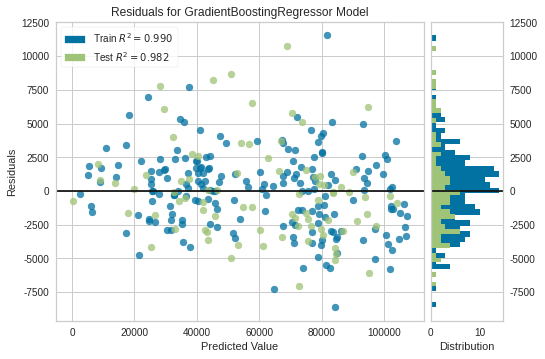

In [ ]:
plot_model(final_model_l, plot='residuals')

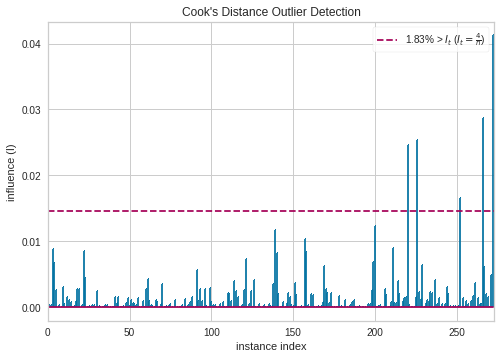

In [ ]:
plot_model(final_model_l, plot='cooks')

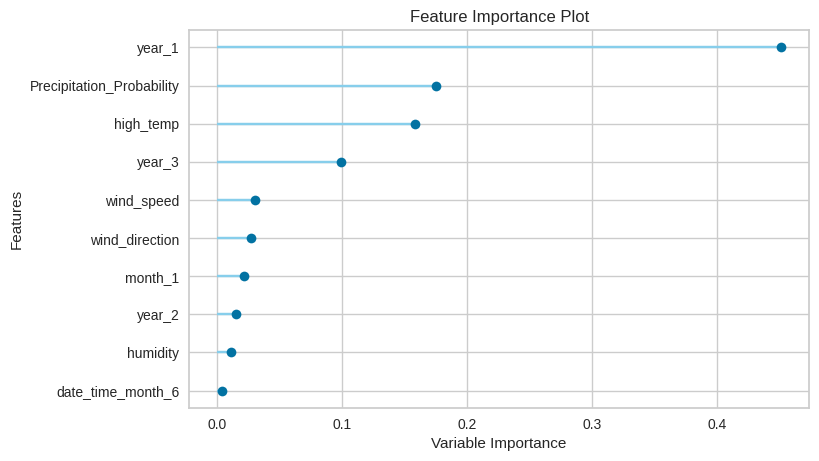

In [ ]:
plot_model(final_model_l, plot='feature')

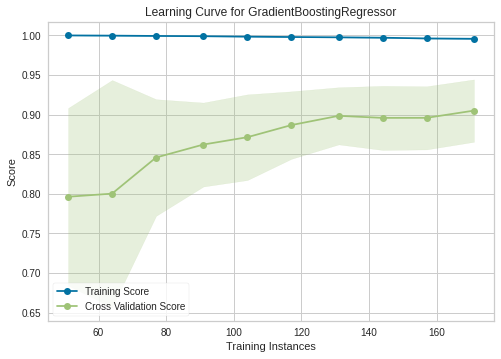

In [ ]:
plot_model(final_model_l, plot='learning')

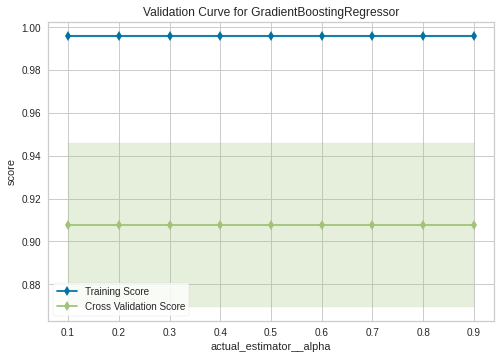

In [ ]:
plot_model(final_model_l, plot='vc')

In [ ]:
pred_esb_l

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,week_day,year,month,day,humidex,weekend,ideal,Label
0,2021-04-01,108.833,3.000,0.000,2.900,28.333,11.800,20.667,18.333,4,4,1,1,64.785676,0,0,71691.855301
1,2021-04-02,116.717,3.850,0.000,2.662,46.417,12.000,19.000,28.500,0,4,1,2,63.783407,0,0,60015.852545
2,2021-04-03,82.669,4.000,0.565,2.165,77.258,8.875,16.368,52.847,2,4,1,3,61.029320,0,0,22898.026098
3,2021-04-04,44.123,3.466,0.466,3.747,63.288,6.250,17.368,37.671,3,4,1,4,62.199837,1,0,35497.529269
4,2021-04-05,147.791,1.500,0.000,1.560,48.176,7.188,18.684,4.459,1,4,1,5,63.456064,0,0,78644.775135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,2021-06-26,177.149,3.980,0.223,1.066,74.628,20.312,28.579,36.486,2,4,3,26,79.891843,0,1,90289.370338
87,2021-06-27,138.723,2.777,0.135,1.290,70.236,20.812,29.000,18.378,3,4,3,27,79.911008,1,1,99117.679844
88,2021-06-28,111.095,3.338,1.270,1.692,70.338,21.000,28.789,35.946,1,4,3,28,79.607867,0,1,96041.163827
89,2021-06-29,171.622,3.270,0.595,1.470,70.473,21.000,29.421,27.770,5,4,3,29,80.579894,0,1,93736.675014


In [ ]:
# submission dataFrame 완성
sample_submission['number_of_rentals'] = pred_esb_l['Label']

# 제출 파일 생성
sample_submission.to_csv('/content/drive/MyDrive/gh/kaggle/dacon/bicycle/dataset/ideal.csv', index= False)